## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Колодяжный Даниил Антонович

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import math
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(2 балл)**

## Срок выполнения задания:
Софт дедлайн - 8 октября 23:59  
Хард дедлайн - 15 октября 23:59


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [15]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [16]:
images_train, labels_train = next(iter(train_loader))

In [17]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

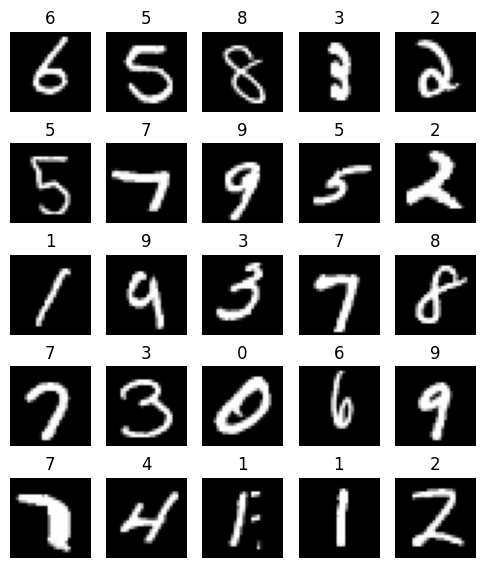

In [18]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [19]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [20]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [21]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

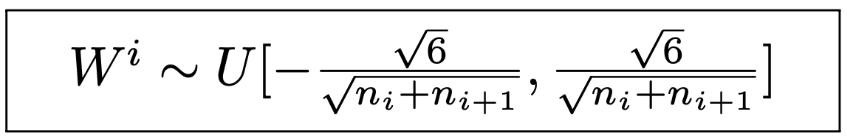

In [22]:
def xavier_uniform(layer):
    if isinstance(layer, nn.Linear):
        # Если линейные слои
        fan_in, fan_out = layer.in_features, layer.out_features
    else:
        # Если сверточные слои
        fan_in = layer.in_channels * layer.kernel_size[0] * layer.kernel_size[1]
        fan_out = layer.out_channels * layer.kernel_size[0] * layer.kernel_size[1]

    a = math.sqrt(6.0 / (fan_in + fan_out + 1))
    with torch.no_grad():
        layer.weight.uniform_(-a, a)
        if layer.bias is not None:
            layer.bias.zero_()

In [26]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

xavier_uniform(layer_1)
xavier_uniform(layer_2)

In [27]:
network = nn.Sequential(layer_1, nn.Tanh(), layer_2)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1)
y = labels_train[:n_objects]

# прямой и обратный проход
logits = network(X)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(logits, y)
loss.backward()

forward 0.9915482401847839
forward 0.6511486172676086
backward 0.04871518537402153
backward 0.006292758043855429


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


##### Для сравнения используем стандартный He + ReLu

In [28]:
import torch.nn.init as init

def init_he_pytorch(layer):
    if (isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d)):
        init.kaiming_normal_(layer.weight, a=0.0, mode='fan_in', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

In [29]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_he_pytorch(layer_1)
init_he_pytorch(layer_2)

In [30]:
network = nn.Sequential(layer_1, nn.Tanh(), layer_2)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1)
y = labels_train[:n_objects]

# прямой и обратный проход
logits = network(X)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(logits, y)
loss.backward()

forward 0.9915482401847839
forward 0.7098049521446228
backward 0.04216153547167778
backward 0.005224409978836775


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


##### Вывод

Xavier + Tanh:  

forward 0.9915482401847839   
forward 0.6511486172676086  
backward 0.04871518537402153  
backward 0.006292758043855429   

ReLU + He:  

forward 0.9915482401847839  
forward 0.7098049521446228  
backward 0.04216153547167778  
backward 0.005224409978836775  

- При Xavier+Tanh СКО активаций падает с ~0.99 до ~0.65, градиент затухает сильнее, чем у ReLU + He, т.к. из-за сжатия tanh градиент затухает сильнее;

- При He+ReLU СКО активаций падает до ~0.71 ~ sqrt(1/2), это согласуется с теорией для ReLU (добавочный коэффициент 1/2 в формулах для дисперсий слоев);

- Вывод: пары Xavier+Tanh и He+ReLU держат масштаб адекватно, но He+ReLU обычно даёт более быструю сходимость, т.к. градиенты затухают чуть слабее, чем у Tanh (за счёт сжатия tanh (и производной < 1) более сильное уменьшение СКО в градиенте.)

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

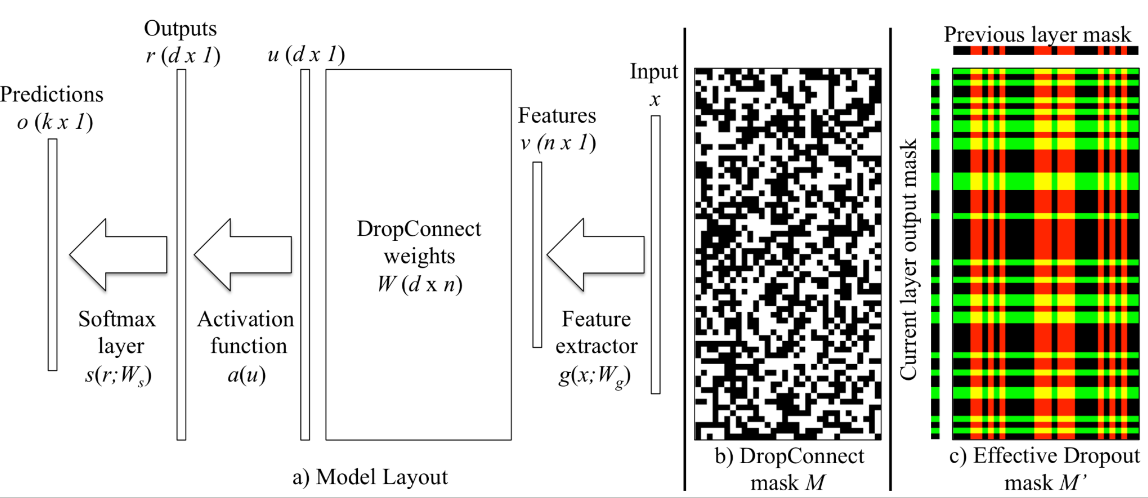

In [31]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight, device=x.device, requires_grad=False)
            mask.bernoulli_(1.0 - self.p)
        else:
            mask = torch.full_like(self.linear.weight, 1.0 - self.p, device=x.device, requires_grad=False)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [32]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [33]:
layers = [
    DropConnect(196, 64, p=0.3),
    nn.ReLU(),
    DropConnect(64, 10, p=0.3),
]

In [34]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [35]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.299013
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.041410
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.653833
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.500262
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.504937
Test Epoch: 0	Loss: 0.319023
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.795413
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.437847
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.344575
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.494165
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.416161
Test Epoch: 1	Loss: 0.223731
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.347599
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.424762
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.257122
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.249891
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.327720
Test Epoch: 2	Loss: 0.159571
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.256550
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.209082
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.187845
Train Epoch: 3 [38400/60000 (64%)

##### Вывод

DropConnect дал стабильное снижение test-loss до ~0.0785 за 10 эпох, без признаков переобучения. Колебания train-loss объясняются вероятностным характером маски весов.


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [36]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Подготовим две конфигурации "Головы" с фиксированной вероятностью

In [37]:
p = 0.3 

# Dropout
final_dropout = nn.Sequential(
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(p),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(p),
    nn.Linear(128, 10), 
)

# DropConnect
final_dropconnect = nn.Sequential(
    DropConnect(196, 128, p=p),
    nn.ReLU(),
    DropConnect(128, 128, p=p),
    nn.ReLU(),
    DropConnect(128, 10, p=p),
)

In [38]:
model_do = TestNetwork(final_dropout)
model_dc = TestNetwork(final_dropconnect)

In [40]:
loss_fn = nn.NLLLoss()
opt_do = torch.optim.Adam(model_do.parameters(), lr=1e-3)
opt_dc = torch.optim.Adam(model_dc.parameters(), lr=1e-3)

In [42]:
def train_one_epoch(model, loader, opt):
    model.train()
    total_loss = 0.0
    total = 0
    for X, y in loader:
        opt.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * X.size(0)
        total += X.size(0)
    return total_loss / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total = 0
    correct = 0
    for X, y in loader:
        out = model(X)
        loss = loss_fn(out, y)
        total_loss += loss.item() * X.size(0)
        total += X.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
    return total_loss / total, correct / total

In [43]:
EPOCHS = 10
hist = {'do_train':[], 'do_test':[], 'do_acc':[],
        'dc_train':[], 'dc_test':[], 'dc_acc':[]}

for epoch in range(EPOCHS):
    tr_do = train_one_epoch(model_do, train_loader, opt_do)
    te_do, acc_do = evaluate(model_do, test_loader)

    tr_dc = train_one_epoch(model_dc, train_loader, opt_dc)
    te_dc, acc_dc = evaluate(model_dc, test_loader)

    hist['do_train'].append(tr_do)
    hist['do_test'].append(te_do)
    hist['do_acc'].append(acc_do)

    hist['dc_train'].append(tr_dc)
    hist['dc_test'].append(te_dc)
    hist['dc_acc'].append(acc_dc)

    print(f'Epoch {epoch:02d} | '
          f'Dropout  : train {tr_do:.4f}  test {te_do:.4f}  acc {acc_do:.4f} | '
          f'DropConnect: train {tr_dc:.4f}  test {te_dc:.4f}  acc {acc_dc:.4f}')

Epoch 00 | Dropout  : train 0.6142  test 0.1942  acc 0.9462 | DropConnect: train 0.7577  test 0.2444  acc 0.9261
Epoch 01 | Dropout  : train 0.1940  test 0.1358  acc 0.9615 | DropConnect: train 0.2638  test 0.1594  acc 0.9503
Epoch 02 | Dropout  : train 0.1480  test 0.1064  acc 0.9704 | DropConnect: train 0.1935  test 0.1257  acc 0.9574
Epoch 03 | Dropout  : train 0.1259  test 0.1031  acc 0.9720 | DropConnect: train 0.1624  test 0.1048  acc 0.9623
Epoch 04 | Dropout  : train 0.1097  test 0.0966  acc 0.9746 | DropConnect: train 0.1418  test 0.0877  acc 0.9703
Epoch 05 | Dropout  : train 0.1034  test 0.0853  acc 0.9747 | DropConnect: train 0.1285  test 0.0835  acc 0.9725
Epoch 06 | Dropout  : train 0.0926  test 0.0814  acc 0.9779 | DropConnect: train 0.1201  test 0.0751  acc 0.9743
Epoch 07 | Dropout  : train 0.0865  test 0.0795  acc 0.9791 | DropConnect: train 0.1127  test 0.0719  acc 0.9753
Epoch 08 | Dropout  : train 0.0811  test 0.0761  acc 0.9802 | DropConnect: train 0.1053  test 0.

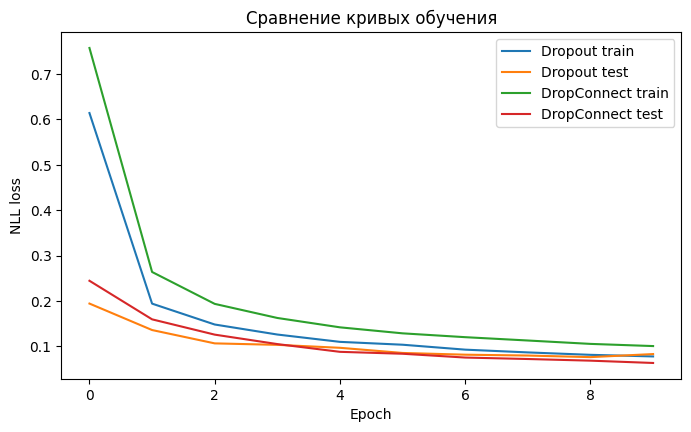

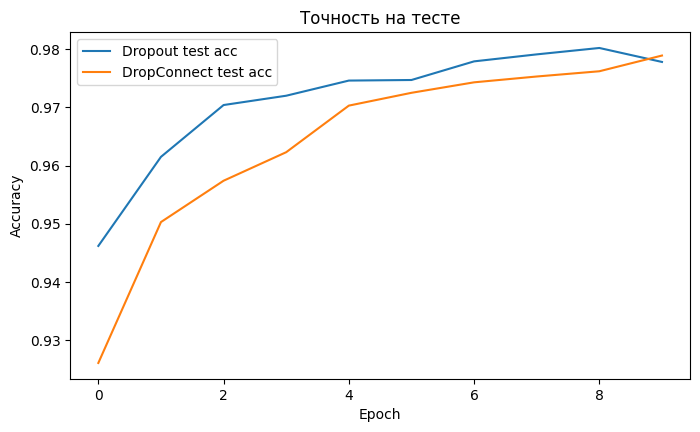

In [44]:
# Лосс
plt.figure(figsize=(8,4.5))
plt.plot(hist['do_train'], label='Dropout train')
plt.plot(hist['do_test'],  label='Dropout test')
plt.plot(hist['dc_train'], label='DropConnect train')
plt.plot(hist['dc_test'],  label='DropConnect test')
plt.xlabel('Epoch'); plt.ylabel('NLL loss'); plt.legend(); plt.title('Сравнение кривых обучения'); plt.show()

# Точность
plt.figure(figsize=(8,4.5))
plt.plot(hist['do_acc'], label='Dropout test acc')
plt.plot(hist['dc_acc'], label='DropConnect test acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Точность на тесте'); plt.show()

##### Вывод:

- Dropout сходится быстрее и имеет меньший train-loss уже с первых эпох.
- DropConnect стартует хуже, train-loss заметно выше в начале,
но постепенно приближается к Dropout, хотя остаётся немного выше и на 10-й эпохе.

Dropout дает шум, как бы с уровня данных, обнуляя активации нейронов, в случае с Dropconnect обучение «скачет» (колебания Loss), поэтому сходится медленнее.

Несмотря на различия в динамике, итоговая точность на тестовой выборке практически одинакова (≈ 98 %), что подтверждает эффективность обоих методов как регуляризаторов.

### Часть 3: Layer Normalization

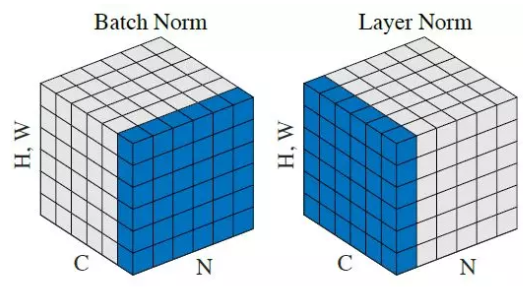

#### 3.1 Реализуйте Layer Normalization **(2 балл)**

In [ ]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape, eps: float = 1e-5):
        super().__init__()

        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
            
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # нормируем по последним len(normalized_shape) осям
        dims = tuple(range(-len(self.normalized_shape), 0))
        mean = x.mean(dim=dims, keepdim=True)
        
        var  = x.var(dim=dims, unbiased=False, keepdim=True)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        
        return x_hat

In [51]:
x = torch.randn(8, 196) # 8 объектов, 196 признаков
ln = LayerNormalization(196)
y = ln(x)

print(y.mean(dim=1).abs().mean().item(), y.std(dim=1).mean().item())

8.66700133883569e-09 1.0025556087493896


#### Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [ ]:
# без нормализации
final_plain = nn.Sequential(
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

# с LayerNorm между всеми слоями
final_ln = nn.Sequential(
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10),
)

In [54]:
model_plain = TestNetwork(final_plain)
model_ln    = TestNetwork(final_ln)

In [55]:
loss_fn = nn.NLLLoss()
opt_plain = torch.optim.Adam(model_plain.parameters(), lr=1e-3)
opt_ln = torch.optim.Adam(model_ln.parameters(), lr=1e-3)


def train_one_epoch(model, loader, opt):
    model.train()
    total_loss, total = 0.0, 0
    for X, y in loader:
        opt.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * X.size(0)
        total += X.size(0)
    return total_loss / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    for X, y in loader:
        out = model(X)
        loss = loss_fn(out, y)
        total_loss += loss.item() * X.size(0)
        total += X.size(0)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
    return total_loss / total, correct / total


EPOCHS = 10
hist = {
    "pl_train": [],
    "pl_test": [],
    "pl_acc": [],
    "ln_train": [],
    "ln_test": [],
    "ln_acc": [],
}

for epoch in range(EPOCHS):
    tr_pl = train_one_epoch(model_plain, train_loader, opt_plain)
    te_pl, acc_pl = evaluate(model_plain, test_loader)

    tr_ln = train_one_epoch(model_ln, train_loader, opt_ln)
    te_ln, acc_ln = evaluate(model_ln, test_loader)

    hist["pl_train"].append(tr_pl)
    hist["pl_test"].append(te_pl)
    hist["pl_acc"].append(acc_pl)
    hist["ln_train"].append(tr_ln)
    hist["ln_test"].append(te_ln)
    hist["ln_acc"].append(acc_ln)

    print(
        f"Epoch {epoch:02d} | "
        f"Plain: train {tr_pl:.4f} test {te_pl:.4f} acc {acc_pl:.4f} | "
        f"LayerNorm: train {tr_ln:.4f} test {te_ln:.4f} acc {acc_ln:.4f}"
    )

Epoch 00 | Plain: train 0.4430 test 0.1530 acc 0.9516 | LayerNorm: train 0.4003 test 0.1835 acc 0.9454
Epoch 01 | Plain: train 0.1368 test 0.1110 acc 0.9661 | LayerNorm: train 0.1473 test 0.1068 acc 0.9668
Epoch 02 | Plain: train 0.0982 test 0.0842 acc 0.9734 | LayerNorm: train 0.0905 test 0.0813 acc 0.9745
Epoch 03 | Plain: train 0.0793 test 0.0820 acc 0.9747 | LayerNorm: train 0.0687 test 0.0738 acc 0.9754
Epoch 04 | Plain: train 0.0673 test 0.0616 acc 0.9800 | LayerNorm: train 0.0565 test 0.0756 acc 0.9753
Epoch 05 | Plain: train 0.0591 test 0.0565 acc 0.9808 | LayerNorm: train 0.0482 test 0.0722 acc 0.9762
Epoch 06 | Plain: train 0.0540 test 0.0575 acc 0.9805 | LayerNorm: train 0.0410 test 0.0890 acc 0.9708
Epoch 07 | Plain: train 0.0472 test 0.0557 acc 0.9818 | LayerNorm: train 0.0354 test 0.0629 acc 0.9791
Epoch 08 | Plain: train 0.0431 test 0.0585 acc 0.9816 | LayerNorm: train 0.0319 test 0.0556 acc 0.9832
Epoch 09 | Plain: train 0.0373 test 0.0549 acc 0.9836 | LayerNorm: train 

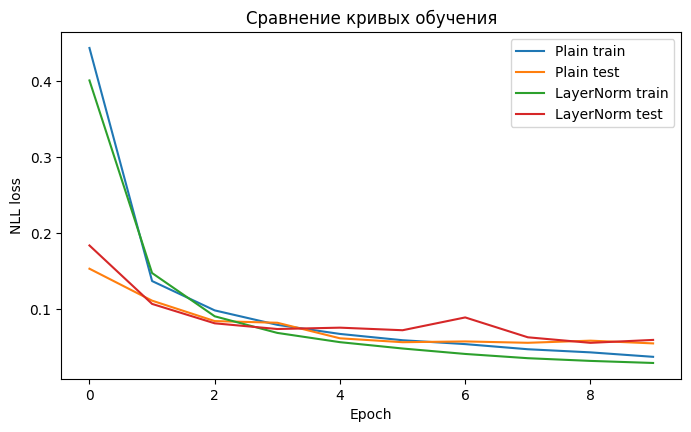

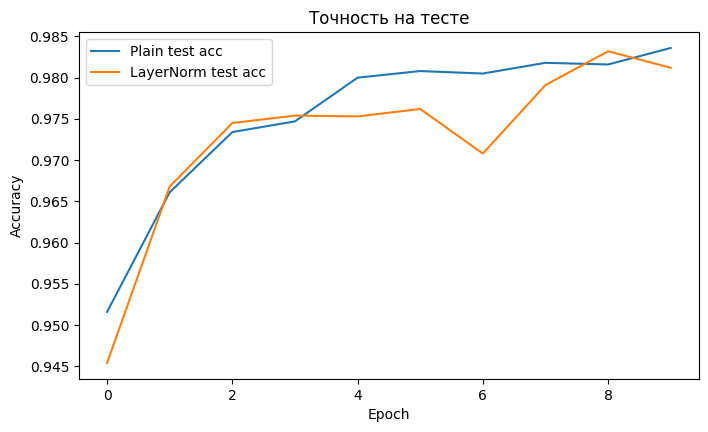

In [56]:
# Лосс
plt.figure(figsize=(8,4.5))
plt.plot(hist['pl_train'], label='Plain train')
plt.plot(hist['pl_test'],  label='Plain test')
plt.plot(hist['ln_train'], label='LayerNorm train')
plt.plot(hist['ln_test'],  label='LayerNorm test')
plt.xlabel('Epoch'); plt.ylabel('NLL loss'); plt.title('Сравнение кривых обучения'); plt.legend(); plt.show()

# Точность
plt.figure(figsize=(8,4.5))
plt.plot(hist['pl_acc'], label='Plain test acc')
plt.plot(hist['ln_acc'], label='LayerNorm test acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Точность на тесте'); plt.legend(); plt.show()

##### Вывод:

Layer Normalization обеспечила более гладкое и стабильное обучение, что выражается в менее шумных кривых функции потерь.
При этом итоговая точность на тестовой выборке практически не изменилась (≈ 98%).

На простом датасете MNIST выигрыш от LayerNorm невелик, однако метод существенно повышает устойчивость обучения.

Таким образом, Layer Normalization стабилизирует процесс оптимизации и снижает чувствительность сети к масштабам входных признаков, сохраняя при этом высокое качество классификации.